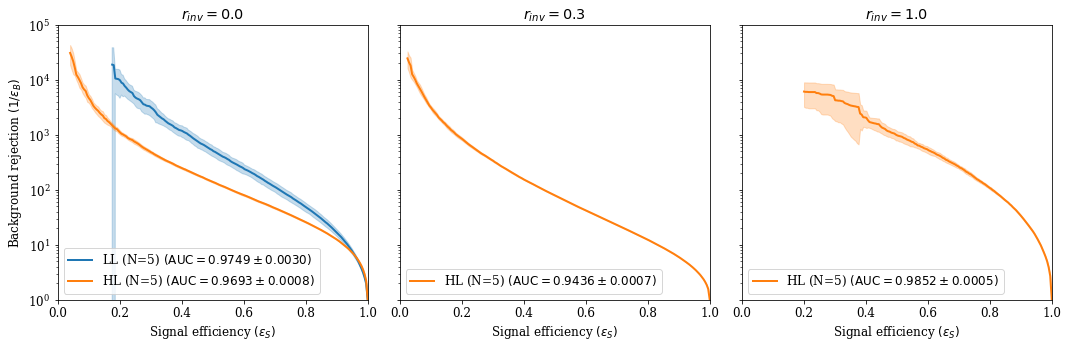

In [86]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pathlib
import warnings
import scipy.stats

path = pathlib.Path.cwd()
warnings.filterwarnings('ignore')

plt.rcParams["font.family"] = "serif"
matplotlib.rcParams.update({'font.size': 12})

colors = {"HL": "tab:orange", "LL": "tab:blue"}

def mean_ci(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

def average_arr(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    n = len(arr)
    m, se = np.mean(arr, axis=-1), scipy.stats.sem(arr, axis=-1)
    h = se * scipy.stats.t.ppf((1 + 0.95) / 2., n-1)
    return m, h

rinvs = ["0p0", "0p3", "1p0"]
HL_LL = ["LL", "HL"]

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for data_type in HL_LL:
    for rix, rinv in enumerate(rinvs):
        # Get AUC values and calculate mean/95% confidence interval
        auc_file = path.parent / f'{data_type}_training' / 'bootstrap_results' / rinv / 'aucs.csv'
        try:
            aucs = pd.read_csv(auc_file).auc
        except:
            break
        auc_avg, auc_ci = mean_ci(aucs)

        # Get roc curve data
        roc_path = path.parent / f'{data_type}_training' / 'bootstrap_results' / rinv / 'roc'
        sig_effs, bkg_effs, bkg_rejs = [], [], []
        x_vals = np.linspace(0,1,200)
        for roc_file in roc_path.glob('*'):
            # get signal/background efficiency and rejection
            roc_df = pd.read_csv(roc_file, index_col=0)
            sig_eff = roc_df.sig_eff.values
            bkg_eff = roc_df.bkg_eff.values
            bkg_rej = 1. / bkg_eff
            
            # Interp to standardize data size
            bkg_eff = np.interp(x_vals, sig_eff, bkg_eff)
            bkg_rej = np.interp(x_vals, sig_eff, bkg_rej)
            
            sig_effs.append(x_vals)
            bkg_effs.append(bkg_eff)
            bkg_rejs.append(bkg_rej)

        # Find the mean of the roc curve data arrays
        mean_sig_eff, ci_sig_eff = average_arr(sig_effs)
        mean_bkg_eff, ci_bkg_eff = average_arr(bkg_effs)
        mean_bkg_rej, ci_bkg_rej = average_arr(bkg_rejs)

        # Define plot labels
        label = '%s (N=%s) $\\left(\mathrm{AUC} = %0.4f \pm %0.4f \\right)$' %(data_type, len(aucs), auc_avg, auc_ci)

        # Plot Title
        ax[rix].set_title("$r_{inv} = %s$" %rinv.replace("p", "."))
        
        # Curve and CI fill_between
        ax[rix].fill_between(mean_sig_eff, mean_bkg_rej - ci_bkg_rej, mean_bkg_rej + ci_bkg_rej, color=colors[data_type], alpha=0.25)
        ax[rix].plot(mean_sig_eff, mean_bkg_rej, lw=2, color=colors[data_type], alpha=1, label=label)
        
        # X and Y labels
        ax[rix].set_xlabel('Signal efficiency $(\epsilon_S)$')
        ax[0].set_ylabel('Background rejection $(1 / \epsilon_B)$')
        
        # Plot details
        ax[rix].set_yscale('log')
        ax[rix].set_xlim(left=0, right=1)
        ax[rix].set_ylim(bottom=1, top=1e5)
        ax[rix].legend(loc='lower left', fontsize="12")
                
# Finalize and save plots
plt.subplots_adjust(wspace=0.1)
plt.tight_layout()
plt.savefig(path.parent / "figures" / "bootstrap_roc.png")
plt.savefig(path.parent / "figures" / "bootstrap_roc.pdf")

KeyboardInterrupt: 

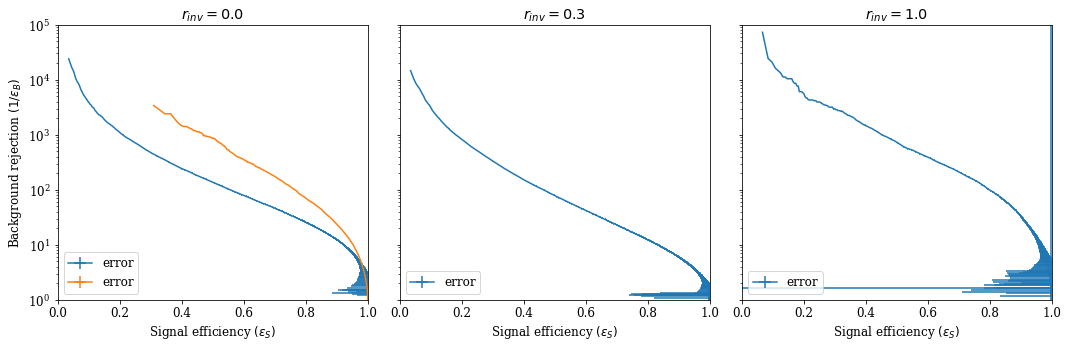

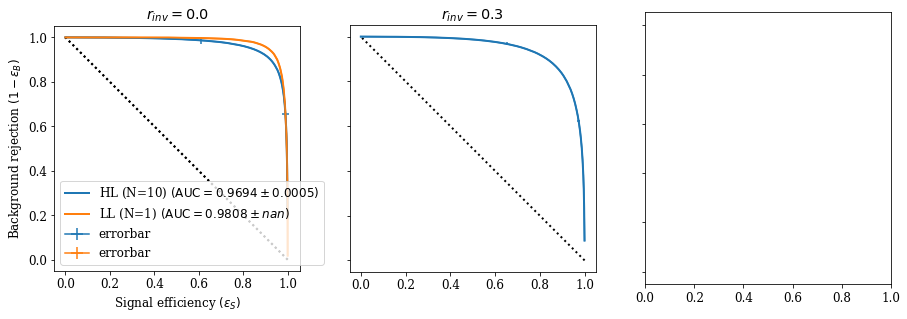

In [83]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import pathlib
import warnings
import scipy.stats

path = pathlib.Path.cwd()
warnings.filterwarnings('ignore')

#plt.rcParams["font.family"] = "serif"
#matplotlib.rcParams.update({'font.size': 12})

def mean_ci(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

def average_curve(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    n = len(arr)
    m, se = np.mean(arr, axis=-1), scipy.stats.sem(arr, axis=-1)
    h = se * scipy.stats.t.ppf((1 + 0.95) / 2., n-1)
    return m, h



rinvs = ["0p0", "0p3", "1p0"]
data_types = ["HL", "LL"]
colors = ["tab:blue", "tab:orange", "tab:green"]
bkgRej_log = True

for bkgRej_log in (True, False):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    for rix, rinv in enumerate(rinvs):
        for data_type in data_types:
            auc_file = path.parent / f'{data_type}_training' / 'bootstrap_results' / rinv / 'aucs.csv'
            if auc_file.exists():
                aucs = pd.read_csv(auc_file).auc.values
                auc_avg, auc_ci = mean_ci(aucs)
                roc_path = path.parent / f'{data_type}_training' / 'bootstrap_results' / rinv / 'roc'
                xs, ys = [], []
                for ix, (roc_file, auc) in enumerate(zip(list(roc_path.glob('*')), aucs)):
                    roc_df = pd.read_csv(roc_file, index_col=0)
                    xs.append(roc_df.sig_eff.values)
                    ys.append(roc_df.bkg_eff.values)
                x, x_ci = average_curve(xs)
                y, y_ci = average_curve(ys)
                while len(x) > 500:
                    x, x_ci = x[::2], x_ci[::2]
                    y, y_ci = y[::2], y_ci[::2]             

                rinv_str = rinv.replace("p", ".")
                if data_type == "HL":
                    color = colors[0]
                else:
                    color = colors[1]
                label = '%s (N=%s) $\\left(\mathrm{AUC} = %0.4f \pm %0.4f \\right)$' %(data_type, len(aucs), auc_avg, auc_ci)
                axs[rix].set_title("$r_{inv} = %s$" %rinv_str)
                if bkgRej_log:
                    #axs[rix].plot(x, 1. / y, lw=2, color=color, alpha=1, label=label)
                    axs[rix].errorbar(x, 1. / y, x_ci, y_ci, color=color, label="error")
                    #axs[rix].fill_between(x, 1. / y_min, 1. / y_max, lw=2, color=color, alpha=0.2)
                    axs[0].set_ylabel('Background rejection $(1 / \epsilon_B)$')
                    axs[rix].set_yscale('log')
                    axs[rix].set_xlim(left=0, right=1)
                    axs[rix].set_ylim(bottom=1, top=1e5)
                    plt.savefig(path.parent / "figures" / "bootstrap_roc.png")
                    plt.savefig(path.parent / "figures" / "bootstrap_roc.pdf")
                else:
                    #axs[rix].fill_between(x, 1. - y_min, 1. - y_max, lw=2, color=color, alpha=0.2)
                    axs[rix].plot([1,0], [0,1], lw=2, color="k", linestyle="dotted")
                    axs[rix].errorbar(x, 1. - y, x_ci, y_ci, color=color, label='errorbar', errorevery=100)
                    axs[rix].plot(x, 1. - y, lw=2, color=color, alpha=1, label=label)
                    axs[0].set_ylabel('Background rejection $(1 - \epsilon_B)$')
                    #axs[rix].set_xlim(left=0, right=1.1)
                    #axs[rix].set_ylim(bottom=0, top=1.1)
                    axs[rix].set_aspect('equal')
                    plt.savefig(path.parent / "figures" / "log_bootstrap_roc.png")
                    plt.savefig(path.parent / "figures" / "log_bootstrap_roc.pdf")
                axs[rix].legend(loc='lower left', fontsize="12")
                axs[rix].set_xlabel('Signal efficiency $(\epsilon_S)$')
    plt.subplots_adjust(wspace=0.1)
    plt.tight_layout()